In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
#pd.set_option("display.precision", 2)
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.3f}'.format
# some imports to set up plotting 
import matplotlib.pyplot as plt
# pip install seaborn 
import seaborn as sns
import reverse_geocoder as revgc

In [2]:
df_train= pd.read_json('C:/Users/admin/train.json')
df_train["training"]=1
#df_train=df_train.drop(columns=['latitude','longitude','listing_id','training'])
df_test= pd.read_json('C:/Users/admin/test.json')
df_test["training"]=0
#df_test=df_test.drop(columns=['latitude','longitude','listing_id','training'])
df= pd.concat([df_train,df_test],sort=True).reset_index(drop=True)

#df_pair=df.drop(columns=['latitude','longitude','listing_id'])
df['nwords_description']= df['description'].apply(lambda x: x.count(' ')+1)

df["len_features"] = df["features"].apply(len)
df["len_photos"] = df["photos"].apply(len)
df["date"]= df['created'].str[:7]
df['created']=pd.to_datetime(df["created"])
df['hr'] = df['created'].dt.hour
df['logprice'] = np.log(df['price'])
df_pair=df.drop(columns=['latitude','longitude','listing_id','training','price','hr'])

#'latitude','longitude',
df['day'] = df['created'].dt.day

df_plt=df.drop(columns=['latitude','longitude','listing_id','day','hr'])
df_plt.loc[df_plt['training']==0,'interest_level'] = 'test'
df['days']=(df["created"]-min(df["created"])).apply(lambda x: x.days)
df['dayofweek'] = df['created'].dt.dayofweek
#df['bathzlomok'] = df['bathrooms'].apply(lambda x: 0 if x.is_integer() else 1)

# GEO
coordinates= df[["latitude","longitude"]].values
coordinates_tuple=tuple((x[0],x[1]) for x in coordinates)
adresy=revgc.search(coordinates_tuple)
df=pd.concat([df,pd.DataFrame(adresy)],axis=1)



Loading formatted geocoded file...


In [3]:
df['admin1'].value_counts()

New York         108701
New Jersey        15224
Western              41
Massachusetts        27
Connecticut           6
California            3
Illinois              2
Pennsylvania          2
Minnesota             1
Indiana               1
Louisiana             1
Texas                 1
Colorado              1
Name: admin1, dtype: int64

In [4]:
def n_features (df,n):   
    x = pd.Series([x for item in df.features for x in item]).value_counts()
    x.head(n)
    x=x.index.values[:n]
    for column in x:
        df[column] = df['features'].apply(lambda row: 1 if column in row else 0) 
    return x

In [5]:
n_features(df,100)

array(['Elevator', 'Cats Allowed', 'Hardwood Floors', 'Dogs Allowed',
       'Doorman', 'Dishwasher', 'No Fee', 'Laundry in Building',
       'Fitness Center', 'Pre-War', 'Laundry in Unit', 'Roof Deck',
       'Outdoor Space', 'Dining Room', 'High Speed Internet', 'Balcony',
       'Swimming Pool', 'Laundry In Building', 'New Construction',
       'Terrace', 'Exclusive', 'Loft', 'Garden/Patio',
       'Wheelchair Access', 'Common Outdoor Space', 'HARDWOOD', 'SIMPLEX',
       'Fireplace', 'prewar', 'LOWRISE', 'Laundry In Unit', 'Garage',
       'Reduced Fee', 'Laundry Room', 'Furnished', 'Multi-Level',
       'Private Outdoor Space', 'Prewar', 'Parking Space',
       'PublicOutdoor', 'Roof-deck', 'dishwasher', 'High Ceilings',
       'elevator', 'Renovated', 'Pool', 'LAUNDRY', 'HIGH CEILINGS',
       'Green Building', 'LIVE IN SUPER', 'High Ceiling',
       'Stainless Steel Appliances', 'Dryer in Unit', 'Washer in Unit',
       'Concierge', 'On-site laundry', 'Storage', 'Newly renovated

In [6]:
#df['feature']= df[column].apply(lambda x: [item.lower() for item in x]) 
x = pd.Series([x for item in df['features'] for x in item]).value_counts()
x

Elevator                                                                                                       64956
Cats Allowed                                                                                                   59194
Hardwood Floors                                                                                                59071
Dogs Allowed                                                                                                   55207
Doorman                                                                                                        52328
                                                                                                               ...  
** HUGE TRUE 2BR HOME * NO FEE * CUSTOM KITCHEN * EXPOSED BRICK * SCENIC ROOF DECK * ELEV BLDG * PETS OK **        1
Not a railroad                                                                                                     1
Secure Electronic Entry                                         

In [82]:
def bar_plot(df,hue,column,normalize='index',counts=False,crosstab=True):
    x=pd.crosstab(df[hue], df[column], normalize=normalize)
    if crosstab==True:
        if counts=='Both': 
            display(x)
        if counts==True: 
            display(pd.crosstab(df[hue], df[column]))
    #fig = plt.figure()
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)
    x.T.plot(kind='bar',ax=ax)  
    plt.grid()

# def make_hist(column,bins=20,label='',normalize=True):
#     hist ,edges=np.histogram(column,bins=bins)
#     width=min(abs(edges[1:]-edges[:-1]))
#     #edges[0]=float('-inf')
#     edges[-1]=float('inf')
#     #edges=edges[:-1]
#     y=hist
#     if normalize:
#         y=hist/column.shape[0]
#     #plt.figure()
#     plt.bar(edges[:-1],y,width=width,align='edge',label=label,alpha=0.4)
#     plt.xlabel(column.name)
#     return edges  

def make_hist(column,bins=20,label='',normalize=True,setx=False,xleft=0, xright=0):
    hist ,edges=np.histogram(column,bins=bins)
    width=min(abs(edges[1:]-edges[:-1]))
    #edges[0]=float('-inf')
    edges[-1]=float('inf')
    #edges=edges[:-1]
    y=hist
    if normalize:
        y=hist/column.shape[0]
    #plt.figure()
    plt.bar(edges[:-1],y,width=width,align='edge',label=label,alpha=0.4)
    
    plt.xlabel(column.name)
    if setx:
        plt.xlim(xleft,xright)
    return edges  
    
def histogram(df,column,hue=False,n_bins=10,normalize=True,setx=False,xleft=0, xright=0):
    if hue == False:
     
        #fig = plt.figure()
        ax = plt.gca()
        for spine in ax.spines.values():
            spine.set_visible(False)
        plt.grid()
       # plt.hist(df[column], density=1, alpha=0.4, bins=n_bins)  
        make_hist(df[column],n_bins,normalize=True,setx=setx,xleft=xleft, xright=xright)
    else:       
        #fig = plt.figure()
        ax = plt.gca()
        for spine in ax.spines.values():
            spine.set_visible(False)
        plt.grid()
        bins=None
        for label_value in df[hue].unique():
            if bins is None: 
                #bins=plt.hist(df[df[hue]==label_value][column], density=1, alpha=0.4, bins=n_bins, label=label_value)
                bins=make_hist(df[df[hue]==label_value][column],n_bins,normalize=True, label=label_value,setx=setx,xleft=xleft, xright=xright)
            else:
                #plt.hist(df[df[hue]==label_value][column], density=1, alpha=0.4,bins=bins[1], label=label_value) 
                make_hist(df[df[hue]==label_value][column],bins=bins,normalize=True, label=label_value,setx=setx,xleft=xleft, xright=xright)
        plt.legend(title=hue)


def graf (df,column,kind,counts,n_bins,normalize='index',hue=False,crosstab=True,setx=False,xleft=0, xright=0):
    if kind=='bar': 
        bar_plot(df,hue,column,normalize,counts,crosstab)
        
    elif kind=='hist':
        histogram(df,column,hue,n_bins,normalize=True,setx=setx,xleft=xleft, xright=xright)

def label_distribution(df,label,column,training,kind,n_bins=10,counts=False,crosstab=True,setx=False,xleft=0, xright=0):
    df=df[df[training]==1]    
    graf(df=df,column=column,kind=kind,hue=label,counts=counts,normalize='columns',n_bins=n_bins,crosstab=crosstab,setx=setx,xleft=xleft, xright=xright) 
    
def compare_distributions (df,label,column,training,n_bins,counts=False,kind='bar',quant=False,typ='both',crosstab=True,setx=False,xleft=0, xright=0):
    if quant >0:
        df=df[df[column]<df.price.quantile(quant)]
    #train vs test
    if typ=='tt':
        graf(df=df,column=column,kind=kind,hue=training,counts=counts,normalize='index',n_bins=n_bins,crosstab=crosstab,setx=setx,xleft=xleft, xright=xright   ) 
    elif typ=='lbl':
        label_distribution(df=df,column=column,kind=kind,label=label,counts=counts,n_bins=n_bins,training=training,crosstab=crosstab,setx=setx,xleft=xleft, xright=xright)
    else:
        plt.figure(figsize=[10,4.8])
        plt.subplot(1,2,1)
        graf(df=df,column=column,kind=kind,hue=training,counts=counts,normalize='index',n_bins=n_bins,crosstab=crosstab,setx=setx,xleft=xleft, xright=xright)    
        plt.subplot(1,2,2)
        label_distribution(df=df,column=column,kind=kind,label=label,counts=counts,n_bins=n_bins,training=training,crosstab=crosstab,setx=setx,xleft=xleft, xright=xright)
        plt.tight_layout()



In [70]:
def overlap (df,training,column):
    listA = df[df[training]==1][column]
    listB = df[df[training]==0][column]
    setA = set(listA)
    setB = set(listB)
    
    A_u=(setA - setB)
    B_u=(setB - setA)
    O_u=(setA & setB)
    
    overlap =len(setA & setB)
    tren_u=len(setA - setB)
    test_u=len(setB - setA)    
    df1 = pd.DataFrame({column:['Overlap', 'Unique training', 'Unique test'], 'val':[overlap, tren_u, test_u]})
    
    tren_u=df[df[column].isin(list(A_u))][column].value_counts().sum()
    test_u=df[df[column].isin(list(B_u))][column].value_counts().sum()
    overlap=df[df[column].isin(list(O_u))][column].value_counts().sum()
    df2 = pd.DataFrame({column:['Overlap', 'Unique training', 'Unique test'], 'val':[overlap, tren_u, test_u]})
    
    plt.figure(figsize=[12,4.8])
    for i,dfi in enumerate([df1,df2]):

        plt.subplot(1,2,i+1)
        plt.bar(dfi[column], height=dfi['val'])
        ax=plt.gca()
        for spine in ax.spines.values():
            spine.set_visible(False)
        plt.grid()
        plt.tight_layout()
def many_categories_table(df,column,training,label,n):
    tr=df[df[training]==1]
    test=df[df[training]==0]
    x=pd.DataFrame(df[column].value_counts())
    x['relative frequency']=x[column]/df.shape[0]
    z=pd.DataFrame(data=tr[column].value_counts()/tr.shape[0])
    z.columns=['relative frequency training']
    y=pd.DataFrame(data=test[column].value_counts()/test.shape[0])
    y.columns=['relative frequency test']
    w=pd.crosstab(df[column], df[label], normalize='index')
    out=x.join(z).join(y).join(w).head(n)
    out=out[[column,'relative frequency','relative frequency test', 'relative frequency training', 'low', 'medium', 'high']]
    return out
def aggregate_hist(df,column,label,n_bins=10):   
    x=pd.crosstab(df[column], df[label], normalize='index')
    plt.figure(figsize=[12,4.8])
    n_cols=len(x.columns)
    for i in range(n_cols):
        plt.subplot(1,n_cols,i+1)
        histogram(x,column=x.columns[i],n_bins=n_bins)

def compare_categorical(df,training,column,label,n=10,n_bins=10):   
    overlap(df,training,column)
    many_categories_table(df,column,training,n)
    aggregate_hist(df,column,label,n_bins=10)

In [66]:
#hrozna funkcia musim prepisat
def n_features (df,column,n):   
    df[column]= df[column].apply(lambda x: [item.lower() for item in x]) 
    x = pd.Series([x for item in df[column] for x in item]).value_counts()
    x.head(n)
    x=x.index.values[:n]
    df2 = pd.DataFrame(columns=[0,1,2,3,4,5,6])

    for item in x:
        df[item] = df[column].apply(lambda row: 1 if item in row else 0) 
        df1=pd.DataFrame(pd.crosstab(df[df[item]==1][item], df['interest_level'],normalize='index'))
        dfx=pd.DataFrame(pd.crosstab(df[df[item]==1][item], df['training']))
        df2= pd.concat([df2,pd.DataFrame([item,(dfx.iloc[0,0]+dfx.iloc[0,1])/df.shape[0],df1.iloc[0,0],df1.iloc[0,1],df1.iloc[0,2],dfx.iloc[0,0]/df_test.shape[0],dfx.iloc[0,1]/df_train.shape[0] ]).T])
    df2.columns=["feature",'relativny pocet',"high","low","medium","relativny pocet test",'relativny pocet trening']
    return df2

In [10]:
def categorical_histogram(df,column,hue=False,n_bins=10,normalize=False):
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.grid()
    bins=None
    for label_value in df[hue].unique():
        x=df[df[hue]==label_value][column].value_counts()
        print(x,label_value)
        if bins is None: 
            #bins=plt.hist(df[df[hue]==label_value][column], density=1, alpha=0.4, bins=n_bins, label=label_value)
            
            bins=make_hist(x,n_bins,normalize=normalize, label=label_value,setx=False,xleft=0, xright=0)
        else:
            #plt.hist(df[df[hue]==label_value][column], density=1, alpha=0.4,bins=bins[1], label=label_value) 
            
            make_hist(x,bins=bins,normalize=normalize, label=label_value,setx=False,xleft=0, xright=0)
        print(bins)
    plt.legend(title=hue)


In [ ]:
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
plt.grid()
bins=None
for label_value in df[hue].unique():
    if bins is None: 
        #bins=plt.hist(df[df[hue]==label_value][column], density=1, alpha=0.4, bins=n_bins, label=label_value)
        bins=make_hist(df[df[hue]==label_value][column],n_bins,normalize=True, label=label_value)
    else:
        #plt.hist(df[df[hue]==label_value][column], density=1, alpha=0.4,bins=bins[1], label=label_value) 
        make_hist(df[df[hue]==label_value][column],bins=bins,normalize=True, label=label_value)
plt.legend(title=hue)

In [62]:
def make_hist(column,bins=20,label='',normalize=True,setx=False,xleft=0, xright=0):
    hist ,edges=np.histogram(column,bins=bins)
    width=min(abs(edges[1:]-edges[:-1]))
    #edges[0]=float('-inf')
    edges[-1]=float('inf')
    #edges=edges[:-1]
    y=hist
    if normalize:
        y=hist/column.shape[0]
    #plt.figure()
    plt.bar(edges[:-1],y,width=width,align='edge',label=label,alpha=0.4)
    
    plt.xlabel(column.name)
    if setx:
        plt.xlim(xleft,xright)
    return edges  

array([ 0.        ,  0.21881948,  0.43763895,  0.65645843,  0.8752779 ,
        1.09409738,  1.31291685,  1.53173633,  1.7505558 ,  1.96937528,
        2.18819475,  2.40701423,  2.6258337 ,  2.84465318,  3.06347265,
        3.28229213,  3.5011116 ,  3.71993108,  3.93875055,  4.15757003,
        4.3763895 ,  4.59520898,  4.81402845,  5.03284793,  5.2516674 ,
        5.47048688,  5.68930635,  5.90812583,  6.1269453 ,  6.34576478,
        6.56458425,  6.78340373,  7.0022232 ,  7.22104268,  7.43986215,
        7.65868163,  7.8775011 ,  8.09632058,  8.31514006,  8.53395953,
        8.75277901,  8.97159848,  9.19041796,  9.40923743,  9.62805691,
        9.84687638, 10.06569586, 10.28451533, 10.50333481, 10.72215428,
       10.94097376, 11.15979323, 11.37861271, 11.59743218, 11.81625166,
       12.03507113, 12.25389061, 12.47271008, 12.69152956, 12.91034903,
       13.12916851, 13.34798798, 13.56680746, 13.78562693, 14.00444641,
       14.22326588, 14.44208536, 14.66090483, 14.87972431, 15.09

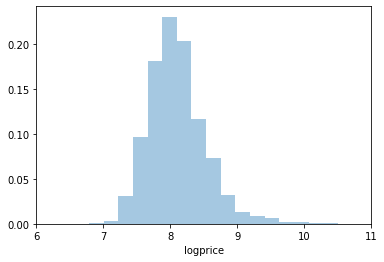

In [74]:
make_hist1(df['logprice'],bins=70,label='',normalize=True,setx=True,xleft=6, xright=11)

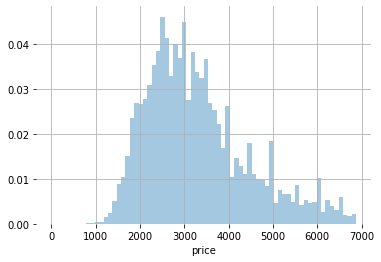

In [92]:
histogram(df[df['price']<df.price.quantile(0.95)],'price',n_bins=70,normalize=True,setx=False,xleft=6.5, xright=10.5)

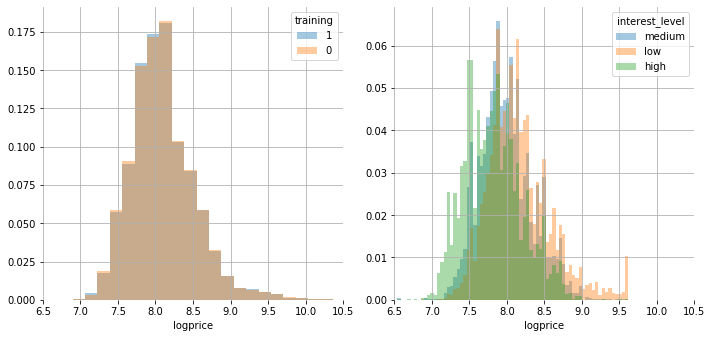

In [85]:
compare_distributions(df=df,label='interest_level',column='logprice',counts=True,training='training',kind='hist',n_bins=70,quant=0.95)

7.824    1106
8.006     840
7.901     777
7.783     772
7.863     707
         ... 
8.029       1
8.047       1
7.956       1
7.940       1
7.560       1
Name: logprice, Length: 830, dtype: int64 1
[1.00000000e+00 1.67857143e+01 3.25714286e+01 4.83571429e+01
 6.41428571e+01 7.99285714e+01 9.57142857e+01 1.11500000e+02
 1.27285714e+02 1.43071429e+02 1.58857143e+02 1.74642857e+02
 1.90428571e+02 2.06214286e+02 2.22000000e+02 2.37785714e+02
 2.53571429e+02 2.69357143e+02 2.85142857e+02 3.00928571e+02
 3.16714286e+02 3.32500000e+02 3.48285714e+02 3.64071429e+02
 3.79857143e+02 3.95642857e+02 4.11428571e+02 4.27214286e+02
 4.43000000e+02 4.58785714e+02 4.74571429e+02 4.90357143e+02
 5.06142857e+02 5.21928571e+02 5.37714286e+02 5.53500000e+02
 5.69285714e+02 5.85071429e+02 6.00857143e+02 6.16642857e+02
 6.32428571e+02 6.48214286e+02 6.64000000e+02 6.79785714e+02
 6.95571429e+02 7.11357143e+02 7.27142857e+02 7.42928571e+02
 7.58714286e+02 7.74500000e+02 7.90285714e+02 8.06071429e+02
 8.218571

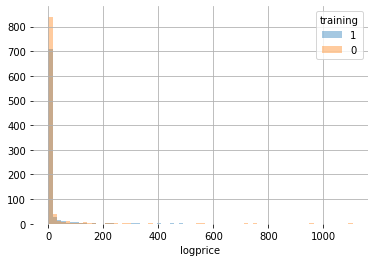

In [21]:
categorical_histogram(df[df['logprice']<df.logprice.quantile(0.5)],'logprice',hue='training',n_bins=70,normalize=False)

# Two Sigma Connect

V tejto súťaži bolo úlouhou predikovať záujem o inzerovaný apartmán na prenájom na základe dát inzerátov pochádzajúcich zo stránky **renthop.com**. Predikovaná cieľová premenná, záujem o apartmán, je definovaná veľkosťou dopytu za obodbie kedy bol inzerát aktívny na stránke. Súbor sa skladá z údajov vyplňovaných pri tvorení inzerátov. Medzi základné informácie patrí počet kúpelní, počet izieb a výška ceny mesačného nájomného, ktorá je uvádzaná v amerických dolároch. Ďalej súbor obsahuje nielen adresy, ale aj údaje o zemepisnej šírke a dĺžke. V súbore sa nachádzajú aj fotky apartmánov, ich opisy a zoznam vlastností, ID manažéra, ID budovy a dátum pridania inzerátu na stránku.  

# 1. EDA - Analýza dát

V rámci kapitoly analýzy dat je potrebné preskúmať a pochopiť charakter dát. Pomocou tabuliek a grafov identifikovať chýbajúce či odlahlé hodnoty pozorovaní a tak pochopiť kvalitu vstupných dát. Podozrivé odľahlé hodnoty môžu byť spôsobené chybným meraním, či nesprávnym vyplnením inzerátov.

Ďalej je potrebné preskúmať, či sa rozdelenia veličin v trénovacom a testovacom súbore významne líšia. V prípade, že by sa výrazne líšili, by bolo vhodné vytvoriť validačnú stratégiu odpovedajúcu rozdeleniu testovacích dát. Veličina s rozdielnymi rozdeleniami by v okrajových prípadoch mohla byť nepoužitelná na modelovanie.

Jedným z hlavných cielov analýzy dát je stanoviť hypotézy o možnej závislosti záujmu o inzerovaný apartmán na ostatných premenných súboru. U spojitých veličín má význam pozerať sa na histogramy pre jednotlivé úrovne záujmu. Využitím percentuálnych stĺpcových grafov u kategorických premenných nadobúdajúcich malý počet hodnôt je možné sledovať, či sa rozdelenie záujmu pre niektoré kategórie líší. Zároveň však treba dbať aj na relatívne zastúpenie danej kategórie v súbore. U premenných s vysokým počtom kategórií nie je možné jednoduché zobrazenie stĺpcových grafov. Jednou z možností je pohľad na počet unikátnych hodnôt prieniku a rozdielov súborov a neskôr aj ich celkový objem. Ďalšou možnosťou je pozrieť sa na top **N** najvyskytovanejších kategórií a ich percentuálne rozdelenie úrovní záujmu o apartmány. Prostredníctvom viacrozmernej analýzy premenných je možné identifikovať potenciálne interakcie premenných využitelné pre spresnenie predikcií.

Trénovací súbor obsahuje 49352 pozorovaní s 15 premennými. Súbor obsahuje širokú škálu premenných ako numerické, kategorické, textové, dátumové či dokonca aj obrázky a súradnice. 
V testovacom súbore sa nachádza 74659 inzerátov, pre ktoré je potrebné predikovať jednu z úrovní záujmu o apartmán. Na prvý pohľad neobsahuje žiadny z inzerátov chýbajúce hodnoty. Predikovaný atribút, záujem o inzerovaný apartmán, môže nadobudnúť jednu z troch úrovní. Najvyskytovanejšou úrovňou záujmu s výskytom v 69% (34284) inzerovaných apartmánov bola v trénovacom súbore **nízka** úroveň. Záujem o 23% (11229) apartmánov bol **stredne** vysoký. **Vysokou** úrovňou záujmu o apartmán bolo klasifikovaných len 8% (3839) apartmánov.  

,training
0,74659
1,49352


,interest_level,interest_level_cnt
low,0.695,34284
medium,0.228,11229
high,0.078,3839


(None, None, <matplotlib.axes._subplots.AxesSubplot at 0x1deea06e688>)

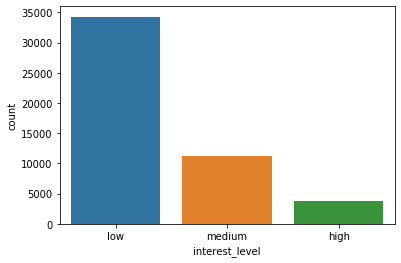

In [7]:
x=pd.DataFrame(df['interest_level'].value_counts(normalize=True))
x['interest_level_cnt']=df['interest_level'].value_counts()
display(pd.DataFrame(df['training'].value_counts())),display(x), sns.countplot(x='interest_level', data=df,order =['low','medium','high'])

In [18]:
df_pair.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124011 entries, 0 to 124010
Data columns (total 15 columns):
bathrooms          124011 non-null float64
bedrooms           124011 non-null int64
building_id        124011 non-null object
created            124011 non-null datetime64[ns]
description        124011 non-null object
display_address    124011 non-null object
features           124011 non-null object
interest_level     49352 non-null object
manager_id         124011 non-null object
photos             124011 non-null object
price              124011 non-null int64
street_address     124011 non-null object
len_features       124011 non-null int64
len_photos         124011 non-null int64
date               124011 non-null object
dtypes: datetime64[ns](1), float64(1), int64(4), object(9)
memory usage: 14.2+ MB


Pomocou základných deskriptívnych štatistík je možné pozorovať že kvantitatívné premenné podliehajú pozitívne zošikmenému rozdeleniu. Hodnota priemeru je vyššia ako hodnota mediánu pre každý z atribútov. Maximálna hotnota pre jednotlivé premenné napovedá, že sa v dátach vyskytujú odľahlé pozorovania. Maximálny počet kúpelní je 112 zatiaľ čo izieb len 8. Taktiež cena 4490000 dolárov za mesačné nájomne sa môže zdať podozrivá. 

In [19]:
df_pair.describe()# graf(df,'bathrooms','hist'),graf(df,'price','hist'),graf(df,'bedrooms','hist')

,bathrooms,bedrooms,price,len_features,len_photos
count,124011.000,124011.000,124011.000,124011.000,124011.000
mean,1.213,1.543,3781.324,5.426,5.615
std,0.595,1.110,15829.876,3.920,3.638
min,0.000,0.000,1.000,0.000,0.000
25%,1.000,1.000,2495.000,2.000,4.000
50%,1.000,1.000,3150.000,5.000,5.000
75%,1.000,2.000,4100.000,8.000,7.000
max,112.000,8.000,4490000.000,39.000,68.000


# Jednorozmerná analýza

V tejto časti sa analyzujú rozdelenia v trénovacom a testovacom súbore originálnych vstupných premenných súboru. Výnimkou sú geodáta, ktoré sa prekódujú do iných informácií, fotky a vlastnosti apartmánu pre ktoré sa vytvoria nové atribúty- počet fotiek a počet vlastností. Taktiež sa analyzuje vplyv premenných na rozdelenie záujmu o apartmány.

## Počet kúpelní

Rozdelenie počtu kúpelní inzerovaných bytov je takmer totožné pre trénovacie a testovacie data.
Pri pohľade na percentuálny stĺpcový graf je ľahko pozorovateľné, že apartmány s viac ako 4 kúpeľnami boli označené nízkym záujmom. Okrem toho aj apartmány ktorých počet kúpeľní obsahuje zlomkovú časť (čo predstavuje oddelený záchod) sú percentuálne nadmerne dominované nízkym záujmom oproti celkovej percentuálnej hodnote nízkeho záujmu. Tieto kategórie však tvoria len veľmi malé percento súboru.

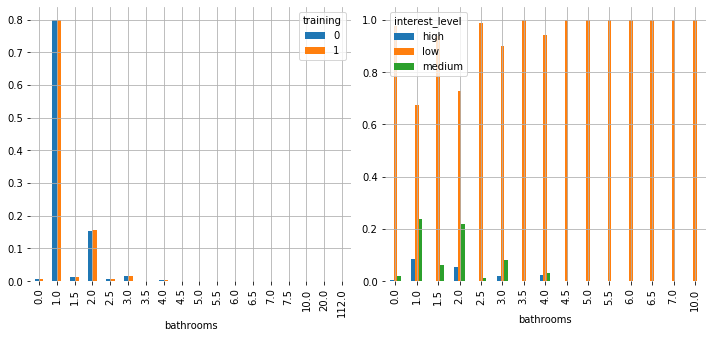

In [60]:
compare_distributions(df=df,label='interest_level',column='bathrooms',counts=False,training='training',kind='bar',n_bins=100,quant=0.95)

## Počet izieb

Stĺpcový percentuálny graf rozdelenia počtu izieb napovedá, že rozdelenia sú veľmi podobné pre trénovacie a testovacie dáta. Kategórie počtu izieb 0, ktorá tvorí 19 percent trénovacieho aj testovacieho súboru, predstavuje 1 izbu zahrňujúcu spálňu a kuchyňu (1+kk) . Pre prvých 5 kategórií počtu izieb (0-4), vyzerá percentuálne rozdelenie záujmu podobne ako v celom súbore. V prípade apartmánov s počtom izieb 5 a viac je záujem zvačša nízky až na prípad 7-izbových apartmánov. Súbor obsahuje však len dva 7-izbové byty, a preto nemá zmysel dávať tejto kategórii veľkú váhu.

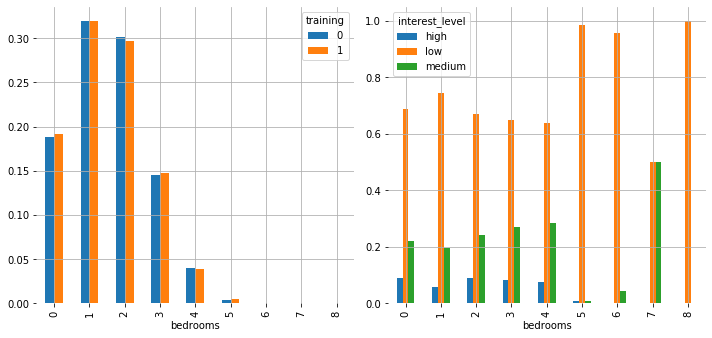

In [14]:
compare_distributions(df=df,label='interest_level',column='bedrooms',counts=False,training='training',kind='bar',n_bins=70,crosstab=False)

## Cena apartmánov

Histogramy zobrazujúce rozdelenia cien apartmánov testovacích a trénovacích dát sú takmer totožné. Naopak, pri pohľade na histogramy cien pre jednotlivé úrovne záujmu o apartmáy je možné vidieť, že vysoký záujem je často spojený s nízkymi cenami. Histogramy nasvedčujú tomu, že s pribúdajúcou cenou je o apartmány nižší záujem. Cena by mohla hrať dôležitú rolu v modeloch.

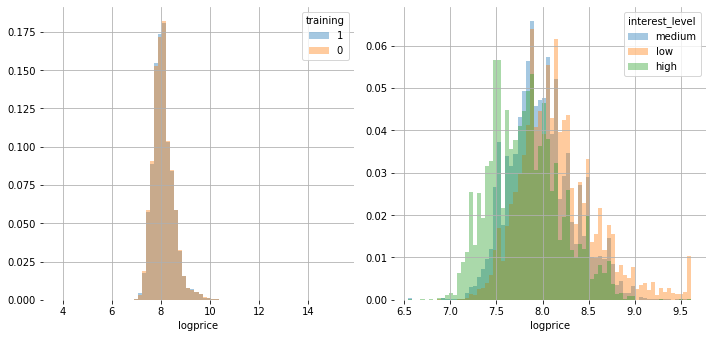

In [13]:
compare_distributions(df=df,label='interest_level',column='logprice',counts=True,training='training',kind='hist',n_bins=70,quant=0.95)

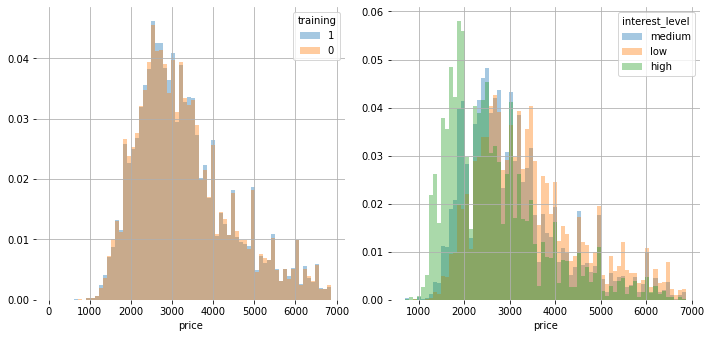

In [7]:
compare_distributions(df=df,label='interest_level',column='price',counts=True,training='training',kind='hist',n_bins=70,quant=0.95)

## Dátum a čas vytvorenia inzerátu

Dôležitou správou je, že trénovacie a testovacie data pochádzajú z rovnakého časového obdobia. V prípade, že by to tak nebolo, by bolo nutné túto informáciu zohľadniť pri výbere validačnej stratégie. Stĺpcový graf napravo nenasvedčuje žiadnej závislosti záujmu o apartmány na mesiaci pridania inzerátu.

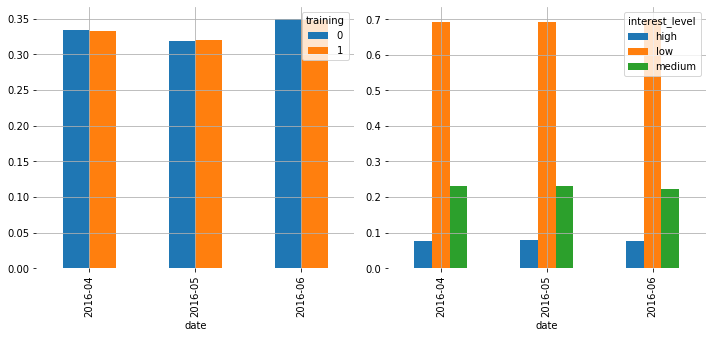

In [43]:
compare_distributions(df=df,label='interest_level',column='date',counts=False,training='training',kind='bar',n_bins=70,crosstab=False)

Stĺpcové grafy pre dni mesiaca a dni týždna taktiež nepreukazujú žiadne rozdiely v rozdelení pre trénovacie a testovacie dáta. Okrem iného neprejavujú žiadne náznaky závislosti záujmu o apartmán na dňoch pridania inzerátu.

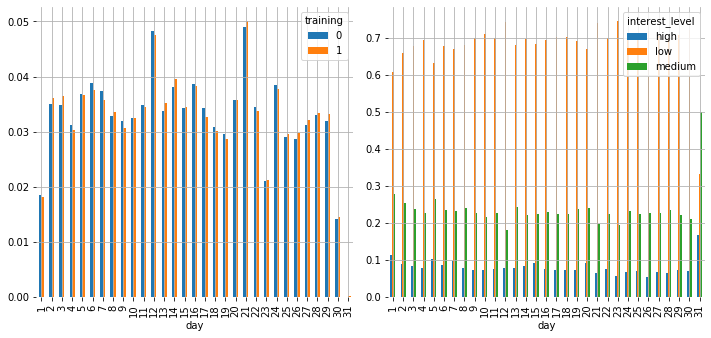

In [17]:
compare_distributions(df=df,label='interest_level',column='day',counts=False,training='training',kind='bar',n_bins=70,crosstab=False)


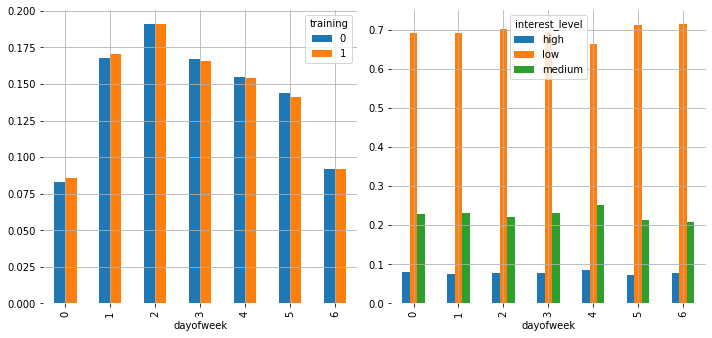

In [18]:
compare_distributions(df=df,label='interest_level',column='dayofweek',counts=False,training='training',kind='bar',n_bins=70,crosstab=False)


Rozdelenia hodín pridanie inzerátu nejavia rozdiely pre trénovací a testovací súbor. Zaujímavé je však sledovať, že vačšina z inzerátov je pridávaná v noci od 1-7 hodiny rannej. Môže sa zdať, že pre rôzne hodiny pridania inzerátov sa mení percentuálne rozdelenie záujmu o apartmán. Inzeráty pridané o 1 v noci sú výrazne častejšie označené nízkym záujmom. Inzeráty pridané v poobedných hodinách boli percentuálne viac označované vyšším záujmom.

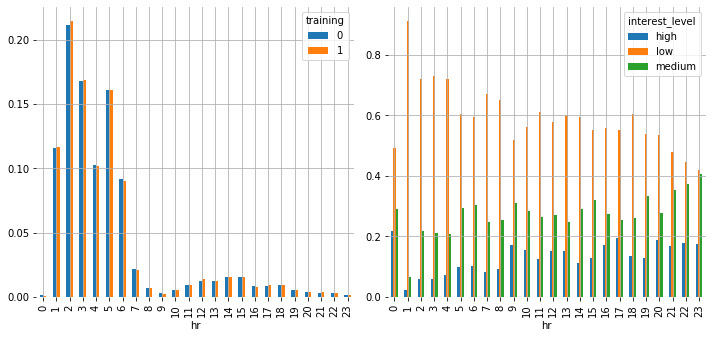

In [19]:
compare_distributions(df=df,label='interest_level',column='hr',counts=False,training='training',kind='bar',n_bins=70,crosstab=False)

## Geo dáta a adresa

Vzhľadom k tomu, že zemepisná šírka a dĺžka niesú intuitívne informácie, boli  pomocou knižnice **reverse_geocoder** transformované na údaje ako kód krajiny, štát, okresy a štvrte. Zadaním súťaže bolo klasifikovať inzerované apartmány na prenájom v New Yorku. Avšak atribút kód krajiny prezrádza, že dáta nekorešpondujú so zadaním. Náchádzajú sa v nich  aj apartmány s kódom krajiny GH, ktorý patrí Ghane. Pri detailnej analýze dát je však možné pozorovať, že zobrazované adresy patria New Yorku, ale zemepisná šírka a dĺžka neboli vyplnené a obsahujú nulové hodnoty patriace Ghane.

In [20]:
df['cc'].value_counts()

US    123970
GH        41
Name: cc, dtype: int64

Hodnoty atribútu štát prezrádzajú ďalšie nezrovnalosti so zadaním, keďže okrem New Yorku a New Jersey sa s veľmi nízkou početnosťou vyskytujú v dátach aj apartmány z Massachusetts, Connecticutu, Kalifornie atď. Existujú štáty,ktoré sa vyskytujú len v trénovacích dátach, ale aj státy, ktoré sa naopak vyskytujú len v testovacích dátach. Pre potreby klasifikácie môže byť zaujímavý fakt, že v štátoch s nízkou početnosťou výskytu skončili apartmány skoro vždy ohodnotené nízkym záujmom.            


In [13]:
df['state']=df['admin1']

(New York         108701
 New Jersey        15224
 Western              41
 Massachusetts        27
 Connecticut           6
 California            3
 Illinois              2
 Pennsylvania          2
 Colorado              1
 Louisiana             1
 Indiana               1
 Texas                 1
 Minnesota             1
 Name: state, dtype: int64, None)

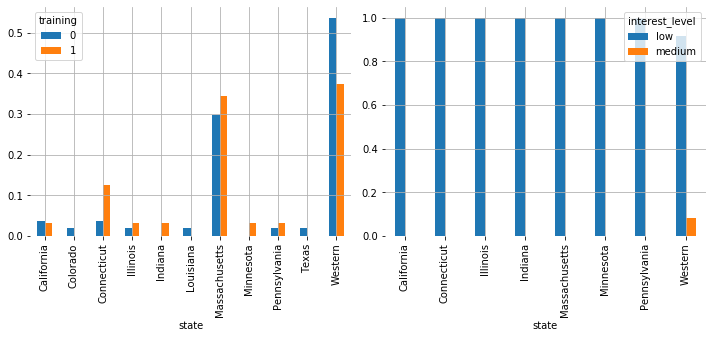

In [14]:
df['state'].value_counts(),compare_distributions(df=df[~df['admin1'].isin(['New Jersey','New York'])],label='interest_level',column='state',counts=False,training='training',kind='bar',n_bins=70,crosstab=False)

Dva najvyskytovanejšie štáty New York a New Jersey sa významne nelíšia v rozdelení v trénovacom a testovacom súbore. Záujem o apartmány v týchto štátoch je rovnako percentuálne rozdelený ako záujem v celom súbore.

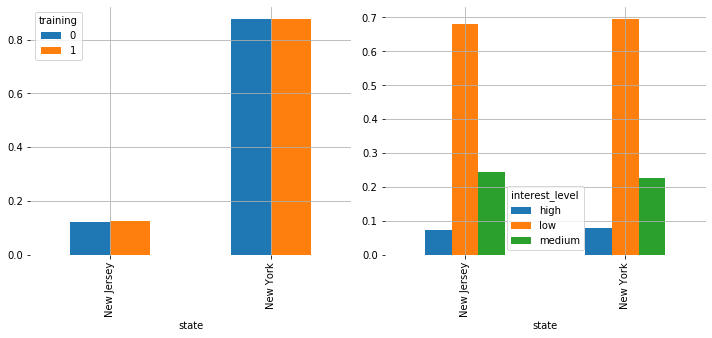

In [15]:
compare_distributions(df=df[df['state'].isin(['New Jersey','New York'])],label='interest_level',column='state',counts=False,training='training',kind='bar',n_bins=70,crosstab=False)

Pri pohľade na nižšiu granularitu geodát, konkrétne na štvrť, sa počet kategórií náramne zvyšuje. Pre zjednodušenie je možné pozrieť sa na tabuľku pre najvyskytovanejších **10** štvrtí. V tréningových a testovacích dátach sú rozdelené veľmi podobne. Manhattan je najvyskytovanejšou kategóriou. Percento apartmánov s nízkym záujmom je v Manhattane výrazne vyššie ako v celom súbore. Naopak apartmány v Brooklyne,Inwoode a Edgewateri majú výrazne vyšší podiel vysokého záujmu oproti hodnote celého súboru. 

In [11]:
df['borough']=df['name']

In [16]:
many_categories_table(df,column='borough',n=10,training='training',label='interest_level')

,borough,relative frequency,relative frequency test,relative frequency training,low,medium,high
Manhattan,38863,0.313,0.313,0.314,0.751,0.196,0.053
New York City,35525,0.286,0.287,0.286,0.697,0.226,0.077
Long Island City,22724,0.183,0.184,0.182,0.678,0.247,0.075
Weehawken,8903,0.072,0.071,0.073,0.673,0.258,0.068
Brooklyn,4440,0.036,0.036,0.036,0.574,0.281,0.145
Edgewater,3246,0.026,0.026,0.026,0.628,0.256,0.116
Inwood,2735,0.022,0.022,0.022,0.582,0.261,0.157
Guttenberg,1687,0.014,0.014,0.014,0.801,0.172,0.027
Borough of Queens,1250,0.010,0.010,0.010,0.566,0.291,0.143
East New York,1238,0.010,0.010,0.010,0.599,0.259,0.143


## ID Budovy

Stĺpcové grafy zobrazujúce prieniky a rozdiely tréningových a testovacích množín ID budov odhaľujú dve dôležité informácie. Graf naľavo zobrazuje unikátne ID budov. V testovacom súbore sa vyskytuje nad 4000 unikátnych budov, ktoré sa nevyskytujú v trénovacom súbore. Počet unikátnych hodnôt vykytujúcich sa v oboch súboroch je skoro len o 1200 viac.

Dôležitú informáciu však odhalil druhý stĺpcový graf, na ktorom vidno, že cca 5200 unikátnych hodnôt, tvoriacich prienik množiny budov trénovacieho a testovacieho datasetu, tvorí prevažnu časť (okolo 120000) celkového objemu atribútu ID budovy.

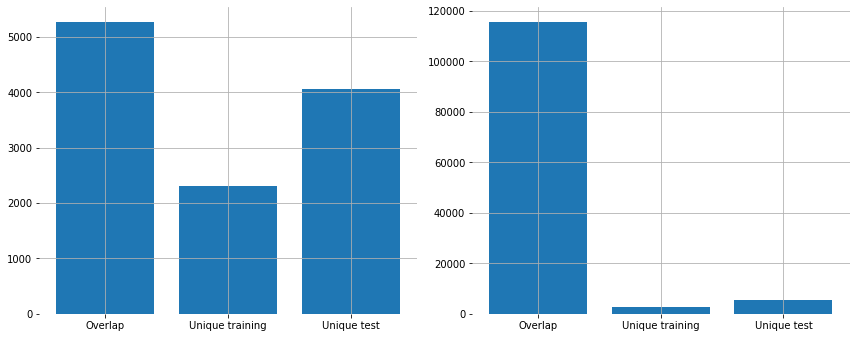

In [41]:
overlap(df,'training','building_id')


Nasledujúca tabuľka top **10** najvyskytovanejších budov odhaľuje informáciu, že inzerátom v ktorých nebolo ID budovy vyplnené, bola priradená hodnota 0. Pozitívne je konštatovanie, že vybrané budovy majú skoro rovnaké percentuálne zastúpenie ako v trénovacích tak v testovacích dátach.O inzeráty, ktoré nemajú vyplnené ID budovy, bol až v 92% prípadov nízkym záujem. Rozdelenie záujmu o apartmány sa líši pre rôzne budovy.

In [17]:
many_categories_table(df,column='building_id',n=10,training='training',label='interest_level')

,building_id,relative frequency,relative frequency test,relative frequency training,low,medium,high
0,20664,0.167,0.166,0.168,0.916,0.061,0.024
96274288c84ddd7d5c5d8e425ee75027,705,0.006,0.006,0.006,0.651,0.273,0.076
11e1dec9d14b1a9e528386a2504b3afc,546,0.004,0.004,0.004,0.674,0.242,0.084
bb8658a3e432fb62a440615333376345,522,0.004,0.004,0.004,0.524,0.354,0.123
80a120d6bc3aba97f40fee8c2204524b,510,0.004,0.004,0.004,0.587,0.329,0.085
ce6d18bf3238e668b2bf23f4110b7b67,459,0.004,0.004,0.003,0.558,0.321,0.121
f68bf347f99df026f4faad43cc604048,457,0.004,0.004,0.004,0.607,0.319,0.073
c94301249b8c09429d329864d58e5b82,410,0.003,0.003,0.003,0.838,0.126,0.036
ea9045106c4e1fe52853b6af941f1c69,397,0.003,0.003,0.003,0.647,0.309,0.043
128d4af0683efc5e1eded8dc8044d5e3,385,0.003,0.003,0.003,0.686,0.242,0.072


## ID Manažéra inzerátu

Zo stĺpcovýh grafov je pozorovatelné, že menej ako 3000 unikátnych manažérov nachádzajúcich sa v oboch súboroch má vo svojej správe viac ako 120 000 inzerátov. V testovacom dátovom súbore sa nachádza niečo pod 1000 nových manžérov. Ich celkový objem je však skoro zanedbateĺný oproti objemu manažerov v oboch súboroch.

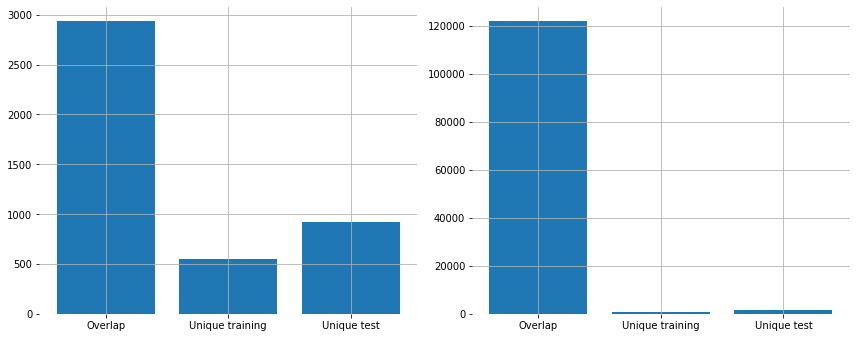

In [38]:
overlap(df,'training','manager_id')

Podľa tabuľky top **10** najvyskytovanejších manažérov inzerátov, existuje manažér ktorý manažuje viac ako 5 percent všetkých inzerátov. Jednotliví manažéri sa vyskytujú s veľmi podobnou relatívnou frekvenciou v trénovacom a testovacom súbore. Až šiesti z top **10** manažérov spravovali viac ako 90% apartmánov, o ktoré bol nízky záujem. Zdá sa že manažér má vplyv na úroveň záujmu o apartmány.

In [12]:
many_categories_table(df,column='manager_id',n=10,training='training',label='interest_level')

,manager_id,relative frequency,relative frequency test,relative frequency training,low,medium,high
e6472c7237327dd3903b3d6f6a94515a,6387,0.052,0.052,0.051,0.687,0.246,0.068
6e5c10246156ae5bdcd9b487ca99d96a,1683,0.014,0.013,0.014,0.906,0.089,0.006
8f5a9c893f6d602f4953fcc0b8e6e9b4,1011,0.008,0.008,0.008,0.988,0.010,0.002
cb87dadbca78fad02b388dc9e8f25a5b,971,0.008,0.008,0.008,0.362,0.491,0.147
62b685cc0d876c3a1a51d63a0d6a8082,956,0.008,0.007,0.008,1.000,0.000,0.000
9df32cb8dda19d3222d66e69e258616b,862,0.007,0.007,0.007,0.827,0.130,0.042
2aa9bfa5f67ed9997ea341dee8a3a271,853,0.007,0.007,0.006,0.516,0.364,0.120
b7de4cb395920136663132057fa89d84,849,0.007,0.007,0.006,0.988,0.013,0.000
ad3d8ddc52c7e0859b5c6c7f7949c3bd,732,0.006,0.006,0.006,0.918,0.079,0.003
c9c33695ee2a2f818e9f1d8f7d1c4b39,731,0.006,0.006,0.006,0.916,0.084,0.000


In [45]:
#aggregate_hist(df,'manager_id','interest_level')

## Počet fotiek

Rozdelenie počtu fotiek v inzerátoch je skoro nerozlíšitelné pre trénovací a testovací dataset. Pri pohľade na histogramy podľa záujmu je na základe dát možné konštatovať, že o inzeráty s 0-2 fotkami a inzeráty s viac ako 20 fotkami je výrazne frekventovanejší nízky záujem.

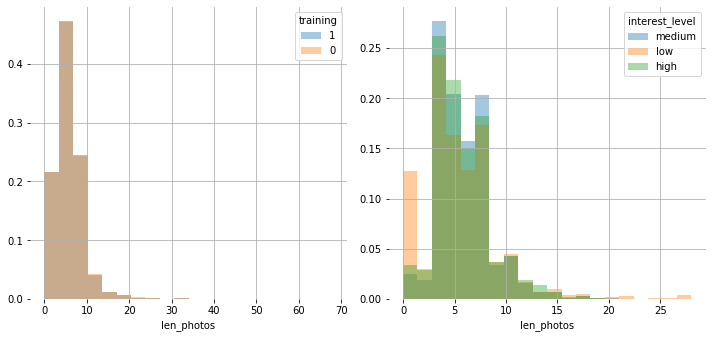

In [46]:
compare_distributions(df=df,label='interest_level',column='len_photos',counts=False,training='training',kind='hist',n_bins=20)

Stĺpcový graf percentuálneho zastúpenia úrovne záujmu pre počty fotiek vačšie ako 20 naznačuje, že o takéto inzeráty ľudia prejavujú nízky záujem výrazne častejšie ako 68% (relatívna frekvencia nízkeho záujmu o apartmán v súbore).

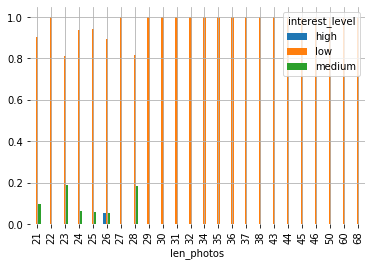

In [31]:
compare_distributions(df=df[(df['len_photos']>20)],label='interest_level',column='len_photos',counts=False,training='training',kind='bar',n_bins=15,typ='lbl',crosstab=False)

## Vlastnosti apartmánu

Histrogramy premennej počtu vlastností pre trénovacie a testovacie dáta vyzerajú takmer totožne. Histogramy pre úrovne záujmu nasvedčujú, že apartmány o ktoré bol veľký záujem, mali výrazne častejšie 0-2 vlastnosti v inzeráte.

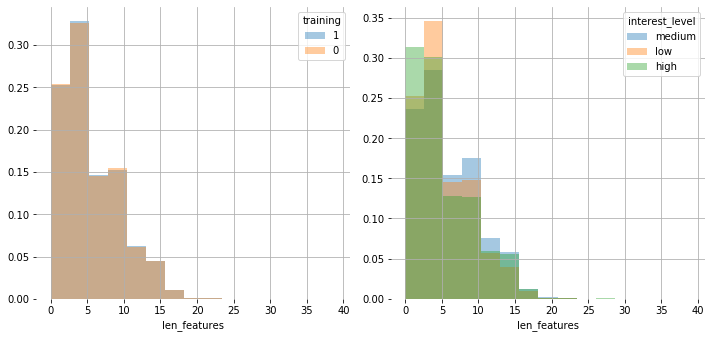

In [32]:
compare_distributions(df=df,label='interest_level',column='len_features',counts=False,training='training',kind='hist',n_bins=15,)

Okrem počtu vlastností je možné sa pozrieť na výskyt jednotlivých vlastností v rámci inzerátov. Originálne dáta nemali zjednotenú veľkosť písma, a tak prvým nutným krokom bolo prepísať všetky hodnoty malým písmom. Ďalším očividným problémom je viacero vlastností s rovnakým významom, ktoré bude v časti spracovania atribútov spojiť do jednej kategórie. Pri pohľade na top **25** najpočetnejších vlastností je evidentné, že napríklad informácia o tom či má apartmán vonkajší priestor je napísané mnohými spôsobmi, ktoré je možné zjednotiť. Pozor si treba dať aj na množné čísla. Mnohé z vlastností majú rovnaké rozdelenie záujmu ako v celom súbore, avšak nájdu sa aj také, ktorých rozdelenie záujmu sa líši.

In [53]:
x=n_features(df,'features',25)
x[['feature','relativny pocet','relativny pocet test', 'relativny pocet trening', 'low', 'medium', 'high']]

,feature,relativny pocet,relativny pocet test,relativny pocet trening,low,medium,high
0,elevator,0.531,0.530,0.532,0.696,0.235,0.069
0,cats allowed,0.477,0.478,0.477,0.725,0.207,0.068
0,hardwood floors,0.477,0.477,0.477,0.627,0.288,0.084
0,dogs allowed,0.445,0.444,0.446,0.730,0.204,0.066
0,doorman,0.423,0.422,0.425,0.732,0.215,0.053
0,dishwasher,0.420,0.418,0.422,0.653,0.273,0.073
0,laundry in building,0.377,0.376,0.378,0.639,0.279,0.082
0,no fee,0.366,0.366,0.366,0.606,0.296,0.098
0,fitness center,0.269,0.270,0.269,0.721,0.224,0.055
0,laundry in unit,0.190,0.190,0.189,0.665,0.265,0.070


## Popis inzerátu

Popisy inzerátov vyžadujú použitie náročnejších metód analýz textu, ktoré prídu na radu v ďalšej časti práce. Pre účely EDA sa však naskytuje možnosť analýzy počtu slov v jednotlivých popisoch inzerátov. Histogramy trénovacích a testovacích dát nenadsvedčujú signifikantné odlišnosti v počte slov popisov. Naopak histogramy pre jednotlivé úrovne záujmu prezrádzajú, že apartmány o ktoré bol nízky záujem, mali nízky počet slov výrazne častejšie ako ostatné úrovne. Inzeráty o ktoré bol stredný a vyšší záujem majú častejšie dlhšie popisy inzerátov.

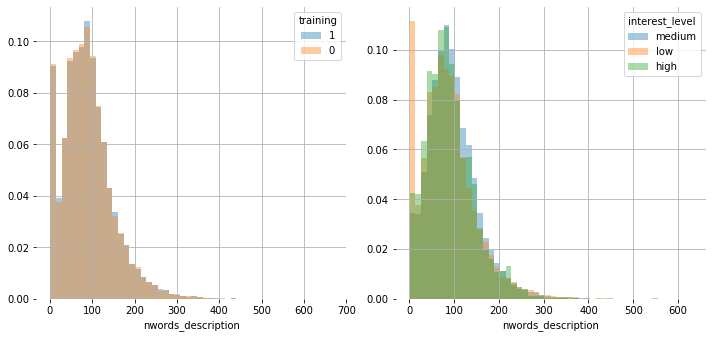

In [40]:
compare_distributions(df=df,label='interest_level',column='nwords_description',counts=False,training='training',kind='hist',n_bins=50)

# Viacrozmerná analýza

Analýzu interakcií vybraných kvantitatívnych premenných umožňuje vizualizácia párového grafu. Ak v grafe dvoch premenných existuje spôsob akým je možné jednoznačne separovať body jednotlivých úrovní záujmu, potom interakcia týchto premenných môže byť doležitou premennou pri modelovaní.

Pri pohľade na riadok ceny je ľahko pozorovateľné, že interakcie premenných s cenou často vedú k relatívne jednoduchému separovaniu úrovní záujmu. Okrem ceny umožňujú jednoduché separovanie bodov aj interakcie premenných s premennými počet slov popisu inzerátu, počet vlastností alebo počet fotiek.

Ďalej je možné sledovať, že o inzeráty apartmánob u ktorých premenné ako počet izieb, počet kúpelní, cena a počet fotiek prekročia istú hranicu je skoro výhradne nízky záujem. Podobné hypotézy vyplynuli aj s jednorozmernej analýzy týchto premenných. 

In [16]:
#sns.pairplot(df_plt[df['price']<15000], hue="interest_level", diag_kind='hist', plot_kws={"alpha":0.9}, diag_kws={"alpha":0.6},hue_order=['low','medium','high','test'])

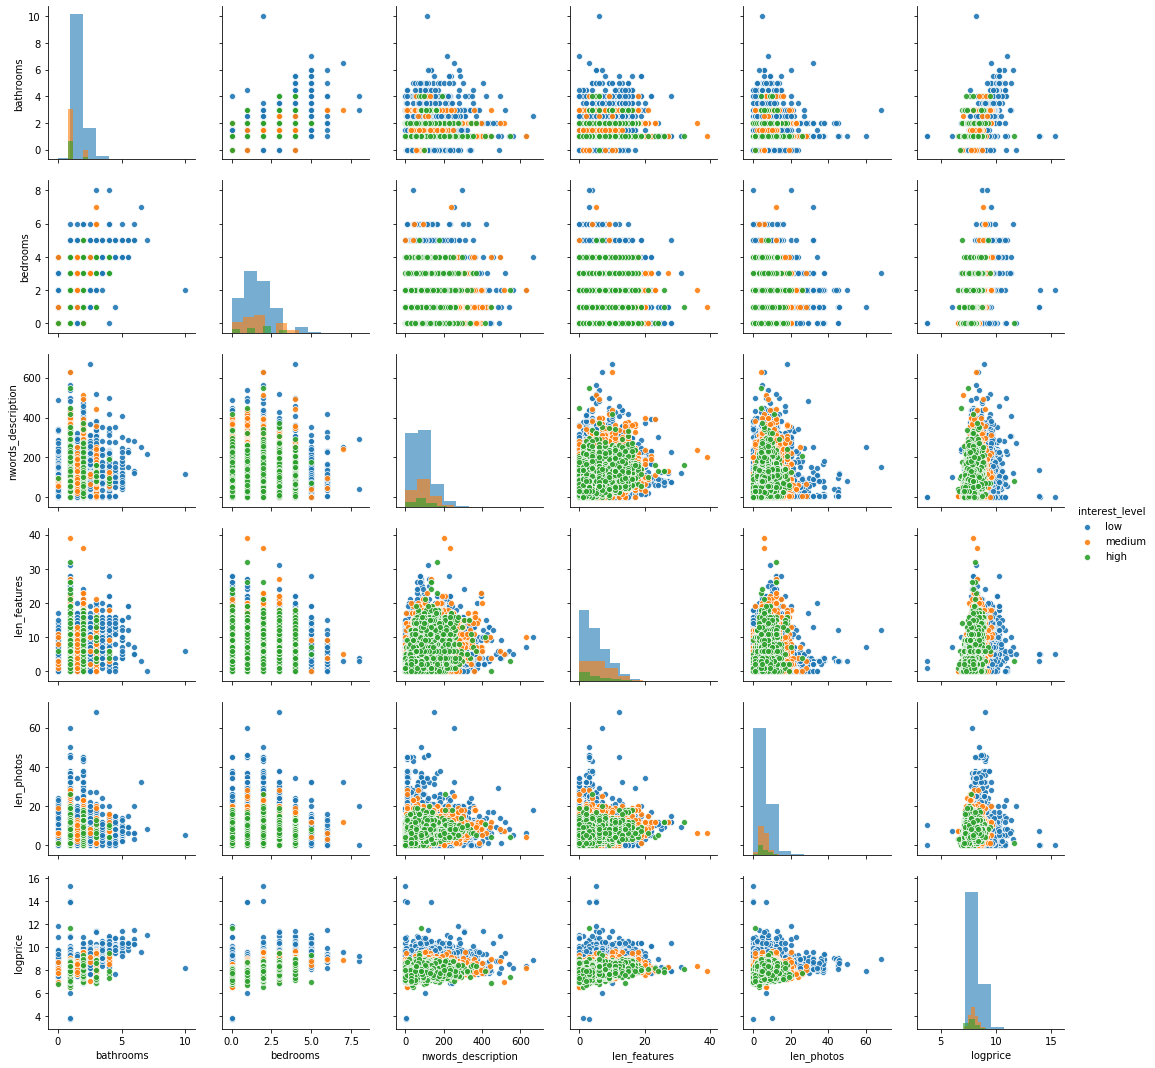

In [18]:
sns.pairplot(df_pair, hue="interest_level", diag_kind='hist', plot_kws={"alpha":0.9}, diag_kws={"alpha":0.6},hue_order=['low','medium','high'])

In [15]:
##sns.pairplot(df_pair[df_pair['price']<15000], hue="interest_level", diag_kind='hist', plot_kws={"alpha":0.9}, diag_kws={"alpha":0.6},hue_order=['low','medium','high'])

Dôležitým záverom analýzy je fakt, že trénovacie a testovacie dáta pochádzajú z rovnakých časových období a preto nie je potrebné použiť časovú validačnú stratégiu. Prienik objemu vysoko kategorických premenných ID budovy a ID manažéra je veľký, čo umožňuje použitie premenných na modelovanie. Ak by bol prienik objemu nízky nebolo by ich možné použiť. Rozdelenia ostatných premenných pre trénovacie a testovacie dáta sa signifikantne nelíšili a preto bude pri modelovaní použitá stratifikovaná krížová validácia.

Premenné cena a počet kúpelní obsahujú odľahlé hodnoty. Naskytuje sa viac alternatív ako sa s nimi pri modelovaní vysporiadať. Pre modely ktoré ovplyvňuje škála vstupných premenných by mohlo byť prínosné tieto atribúty transformovať. Premenné ako cena je možné napríklad škálovať alebo zlogaritmovať. V prípade že sa odľahlé pozorovania nachádzajú v testovacom súbore je ďaľšou z alternatív nahradenie hodnoty najvyššou hodnotou z trénovacieho súboru.

Výsledky analýzy napovedajú, že všetky premenné ovplyvňovali úroveň záujmu o apartmán. Pri niektorých premenných, však záležalo na detaile informácie. Pri dátume vytvorenia inzerátu je dôležitá hodina pridania inzerátu. Geodáta na úrovni štátu neovplyvňovali rozdelenie záujmu. Na úrovni štvrte sa však už rozdelenia úrovne záujmu líšili. Jednorozmerná analýza premenných počet kúpelní, počet izieb, cena, ID budovy a ID manažera nasvedčujú, že spominané premenné budú hrať ústrednú rolu pri predikovaní záujmu. Viacrozmerná analýza nasvedčuje že pre predikcie záujmu môžu byť dôležité interakcie premenných cena, počet slov v popise inzerátu, počet vlastností a počet fotiek.




